### **Version 3**: adding inference for saved models
### **Version 4**: adding fine-tuning pipeline
### **Version 5**: adding split based training
### **Version 6**: adding adversarial validation & training longer

In [1]:
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import gc
import warnings
warnings.simplefilter("ignore")

In [2]:
max_length = 80
num_point  = 82

embed_dim  = 512
num_head   = 4
num_block  = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import torch

num_class  = 250
num_landmark = 543

class HardSwish(nn.Module):
    def __init__(self,):
        super().__init__()
    def forward(self, x):
        return x * F.relu6(x+3) * 0.16666667

class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, embed_dim),
        )
    def forward(self, x):
        return self.mlp(x)

#https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
class MultiHeadAttention(nn.Module):
    def __init__(self,
            embed_dim,
            num_head,
            batch_first,
        ):
        super().__init__()
        self.mha = nn.MultiheadAttention(
            embed_dim,
            num_heads=num_head,
            bias=True,
            add_bias_kv=False,
            kdim=None,
            vdim=None,
            dropout=0.0,
            batch_first=batch_first,
        )

    def forward(self, x, x_mask):
        out, _ = self.mha(x,x,x, key_padding_mask=x_mask)
        return out

class TransformerBlock(nn.Module):
    def __init__(self,
        embed_dim,
        num_head,
        out_dim,
        batch_first=True,
    ):
        super().__init__()
        self.attn  = MultiHeadAttention(embed_dim, num_head,batch_first)
        self.ffn   = FeedForward(embed_dim, out_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(out_dim)

    def forward(self, x, x_mask=None):
        x = x + self.attn((self.norm1(x)), x_mask)
        x = x + self.ffn((self.norm2(x)))
        return x


def positional_encoding(length, embed_dim):
    dim = embed_dim//2
    position = np.arange(length)[:, np.newaxis]     # (seq, 1)
    dim = np.arange(dim)[np.newaxis, :]/dim   # (1, dim)
    angle = 1 / (10000**dim)         # (1, dim)
    angle = position * angle    # (pos, dim)
    pos_embed = np.concatenate(
        [np.sin(angle), np.cos(angle)],
        axis=-1
    )
    pos_embed = torch.from_numpy(pos_embed).float()
    return pos_embed

def pack_seq(
    seq,
):
    length = [min(s.shape[0], max_length)  for s in seq]
    batch_size = len(seq)
    K = seq[0].shape[1]
    L = max(length)

    x = torch.zeros((batch_size, L, K, 3)).to(seq[0].device)
    x_mask = torch.zeros((batch_size, L)).to(seq[0].device)
    for b in range(batch_size):
        l = length[b]
        x[b, :l] = seq[b][:l]
        x_mask[b, l:] = 1
    x_mask = (x_mask>0.5)
    x = x.reshape(batch_size,-1,K*3)
    return x, x_mask

#########################################################################

class Net(nn.Module):

    def __init__(self, num_class=num_class):
        super().__init__()
        self.output_type = ['inference', 'loss']

        pos_embed = positional_encoding(max_length, embed_dim)
        # self.register_buffer('pos_embed', pos_embed)
        self.pos_embed = nn.Parameter(pos_embed)

        self.cls_embed = nn.Parameter(torch.zeros((1, embed_dim)))
        self.x_embed = nn.Sequential(
            nn.Linear(num_point * 3, embed_dim, bias=False),
        )

        self.encoder = nn.ModuleList([
            TransformerBlock(
                embed_dim,
                num_head,
                embed_dim,
            ) for i in range(num_block)
        ])
        self.logit = nn.Linear(embed_dim, num_class)

    def forward(self, batch):
        xyz = batch['xyz']
        x, x_mask = pack_seq(xyz)
        #print(x.shape, x_mask.shape)
        B,L,_ = x.shape
        x = self.x_embed(x)
        x = x + self.pos_embed[:L].unsqueeze(0)

        x = torch.cat([
            self.cls_embed.unsqueeze(0).repeat(B,1,1),
            x
        ],1)
        x_mask = torch.cat([
            torch.zeros(B,1).to(x_mask),
            x_mask
        ],1)


        #x = F.dropout(x,p=0.25,training=self.training)
        for block in self.encoder:
            x = block(x,x_mask)

        cls = x[:,0]
        cls = F.dropout(cls,p=0.4,training=self.training)
        logit = self.logit(cls)

        output = {}
        if 'loss' in self.output_type:
            output['label_loss'] = F.cross_entropy(logit, batch['label'])

        if 'inference' in self.output_type:
            output['sign'] = torch.softmax(logit,-1)

        return output





def run_check_net():

    length = [3,4]
    batch_size = len(length)
    xyz = [
        np.random.uniform(-1,1,(length[b],num_point,3)) for b in range(batch_size)
    ]
    #---
    batch = {
        'label' : torch.from_numpy( np.random.choice(250,(batch_size))).long(),
        'xyz' : [torch.from_numpy(x).float() for x in xyz]
    }

    net = Net()
    output = net(batch)


    #---
    """

    print('batch')
    for k, v in batch.items():
        if k in ['label','x']:
            print(f'{k:>32} : {v.shape} ')
        if k=='xyz':
            print(f'{k:>32} : {v[0].shape} ')
            for i in range(1,len(v)):
                print(f'{" ":>32} : {v[i].shape} ')

    print('output')
    for k, v in output.items():
        if 'loss' not in k:
            print(f'{k:>32} : {v.shape} ')
    print(output['sign'])
    print('loss')
    for k, v in output.items():
        if 'loss' in k:
            print(f'{k:>32} : {v.item()} ')

"""

# main #################################################################
if __name__ == '__main__':
    run_check_net()

# Dataset

In [4]:
# additional helper functions
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path, type='parquet'):
    data_columns = ['x', 'y', 'z']
    if type=='parquet':    
        data = pd.read_parquet(pq_path, columns=data_columns)
    else:
        data = pd.read_csv(pq_path, usecols=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [5]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold
from torch.utils.data import SequentialSampler, RandomSampler

def read_kaggle_csv_by_random(fold=0):
    num_fold = 5

    kaggle_df = pd.read_csv('/kaggle/input/asl-demo/train_prepared.csv')
    train_df = kaggle_df[kaggle_df.fold!=fold].reset_index(drop=True)
    valid_df = kaggle_df[kaggle_df.fold==fold].reset_index(drop=True)
    return train_df, valid_df

def read_kaggle_csv_by_part(fold=0):
    num_fold = 5

    kaggle_df = pd.read_csv('/kaggle/input/asl-demo/train_prepared.csv')
    kaggle_df.loc[:, 'fold' ] = -1
    
    sgkf = StratifiedGroupKFold(n_splits=num_fold, random_state=123, shuffle=True)
    for i, (train_index, valid_index) in enumerate(sgkf.split(kaggle_df.path, kaggle_df.label, kaggle_df.participant_id)):
        kaggle_df.loc[valid_index,'fold'] = i
        #print(kaggle_df.loc[train_index,'fold'])

    #kaggle_df.loc[:, 'fold'] = np.arange(len(kaggle_df))%num_fold
    train_df = kaggle_df[kaggle_df.fold!=fold].reset_index(drop=True)
    valid_df = kaggle_df[kaggle_df.fold==fold].reset_index(drop=True)
    return train_df, valid_df

def read_christ_csv_by_part(fold=0):
    kaggle_df = pd.read_csv('/kaggle/input/asl-demo/train_prepared.csv')
    christ_df = kaggle_df
    
    christ_df = christ_df.merge(kaggle_df[['path']], on='path',validate='1:1') # also kaggle_df['num_frame'] was there removed it
    valid_df = christ_df[christ_df.fold==fold].reset_index(drop=True)
    train_df = christ_df[christ_df.fold!=fold].reset_index(drop=True)
    return train_df, valid_df


def pre_process(xyz):
    #xyz = xyz - xyz[~torch.isnan(xyz)].mean(0,keepdims=True) #noramlisation to common maen
    #xyz = xyz / xyz[~torch.isnan(xyz)].std(0, keepdims=True)
    
    LIP = [
            61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
            291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
            78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
            95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
        ]
    
    lip   = xyz[:, LIP]
    lhand = xyz[:, 468:489]
    rhand = xyz[:, 522:543]
    xyz = torch.cat([ #(none, 82, 3)
        lip,
        lhand,
        rhand,
    ],1)
    xyz[torch.isnan(xyz)] = 0
    xyz = xyz[:max_length]
    return xyz


#-----------------------------------------------------
def train_augment(xyz):
    xyz = do_random_affine(
        xyz,
        scale  = (0.7,1.3),
        shift  = (-0.08,0.08),
        degree = (-20,20),
        p=0.8
    )
    return xyz


class SignDataset(Dataset):
    def __init__(self, df, augment=None):
        self.df = df
        self.augment = augment
        self.length = len(self.df)

    def __str__(self):
        num_participant_id = self.df.participant_id.nunique()
        string = ''
        string += f'\tlen = {len(self)}\n'
        string += f'\tnum_participant_id = {num_participant_id}\n'
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        pq_file = f'/kaggle/input/asl-signs/{d.path}'
        xyz = load_relevant_data_subset(pq_file)
#         print(xyz)
        xyz = xyz - xyz[~np.isnan(xyz)].mean(0,keepdims=True) #noramlisation to common maen
        xyz = xyz / xyz[~np.isnan(xyz)].std(0, keepdims=True)

        #--
#         if self.augment is not None:
#             xyz = self.augment(xyz)
#         print(xyz)
        #--
        xyz = torch.from_numpy(xyz).float()
        xyz = pre_process(xyz)

        r = {}
        r['index'] = index
        r['d'    ] = d
        r['xyz'  ] = xyz
        r['label'] = d.label
        return r


tensor_key = ['xyz', 'label']
def null_collate(batch):
    batch_size = len(batch)
    d = {}
    key = batch[0].keys()
    for k in key:
        d[k] = [b[k] for b in batch]
    d['label'] = torch.LongTensor(d['label'])
    return d




#################################################################################

def run_check_dataset():

    train_df, valid_df = read_kaggle_csv_by_part(fold=0)
    dataset = SignDataset(valid_df)
    print(dataset)

    for i in range(12):
        r = dataset[i]
        print(r['index'], '--------------------')
        print(r["d"], '\n')
        for k in tensor_key:
            if k =='label': continue
            v = r[k]
            print(k)
            print('\t', 'dtype:', v.dtype)
            print('\t', 'shape:', v.shape)
            if len(v)!=0:
                print('\t', 'min/max:', v.min().item(),'/', v.max().item())
                print('\t', 'is_contiguous:', v.is_contiguous())
                print('\t', 'values:')
                print('\t\t', v.reshape(-1)[:5].data.numpy().tolist(), '...')
                print('\t\t', v.reshape(-1)[-5:].data.numpy().tolist())
        print('')
        if 0:
            #draw
            cv2.waitKey(1)



    loader = DataLoader(
        dataset,
        sampler=SequentialSampler(dataset),
        batch_size=8,
        drop_last=True,
        num_workers=0,
        pin_memory=False,
        worker_init_fn=lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
        collate_fn=null_collate,
    )
    print(f'batch_size   : {loader.batch_size}')
    print(f'len(loader)  : {len(loader)}')
    print(f'len(dataset) : {len(dataset)}')
    print('')

    for t, batch in enumerate(loader):
        if t > 5: break
        print('batch ', t, '===================')
        print('index', batch['index'])

        for k in tensor_key:
            v = batch[k]

            if k =='label':
                print('label:')
                print('\t', v.data.numpy().tolist())

            if k =='x':
                print('x:')
                print('\t', v.data.shape)

            if k =='xyz':
                print('xyz:')
                for i in range(len(v)):
                    print('\t', v[i].shape)

        if 1:
            pass
        print('')


# main #################################################################
if __name__ == '__main__':
    run_check_dataset()

	len = 22959
	num_participant_id = 5

0 --------------------
path                      train_landmark_files/49445/1000397667.parquet
participant_id                                                    49445
sequence_id                                                  1000397667
sign                                                             vacuum
landmark_file_path    /home/user/Data/asl-signs/train_landmark_files...
npy_file_path         /home/user/Data/asl-signs/train_features_npy_f...
label                                                               231
fold                                                                  0
Name: 0, dtype: object 

xyz
	 dtype: torch.float32
	 shape: torch.Size([33, 82, 3])
	 min/max: -1.4137358665466309 / 1.5335360765457153
	 is_contiguous: True
	 values:
		 [0.4290144741535187, 0.43524935841560364, -0.8092206120491028, 0.4351654648780823, 0.4245232045650482] ...
		 [1.5183755159378052, -0.9306944608688354, 0.30079182982444763, 1.5102177858352661

# Train

In [6]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'

In [7]:
# additional helper functions 2
#assum zero-mean one-std, input
def do_random_affine(xyz, scale=(0.8, 1.5), shift=(-0.1, 0.1), degree=(-15, 15), p=0.5):
    transformed_xyz = np.copy(xyz)  # Create a copy of xyz to store transformed values

    if np.random.rand() < p:
        if scale is not None:
            scale_factor = np.random.uniform(*scale)
            transformed_xyz = scale_factor * transformed_xyz

        if shift is not None:
            shift_value = np.random.uniform(*shift)
            transformed_xyz = transformed_xyz + shift_value

        if degree is not None:
            degree_value = np.random.uniform(*degree)
            radian = degree_value / 180 * np.pi
            c = np.cos(radian)
            s = np.sin(radian)
            rotate = np.array([[c, -s], [s, c]]).T
            transformed_xyz[..., :2] = transformed_xyz[..., :2] @ rotate

    return transformed_xyz
            
def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

    else:
        raise NotImplementedError


### RAdam and Lookahead

In [8]:
import torch
from torch.optim import Optimizer
from collections import defaultdict
import math
from timeit import default_timer as timer

In [9]:
def np_cross_entropy(probability, truth):
    p = np.clip(probability,1e-4,1-1e-4)
    logp = -np.log(p)
    loss = logp[np.arange(len(logp)),truth]
    loss = loss.mean()
    return loss

In [10]:
from torch.optim import AdamW
from tqdm import tqdm

fold_type = 'christ-part'
fold     = 2
out_dir  = '/kaggle/input' + '/result/run10/transfomer-80-256-lip-hand-3a'
fold_dir = out_dir+ f'/fold-{fold}-{fold_type}'

start_lr = 1e-4
batch_size = 64
num_epoch = 16
save_iter = 5

train_df, valid_df = read_christ_csv_by_part(fold)
train_dataset = SignDataset(train_df,train_augment)
valid_dataset = SignDataset(valid_df,)

train_loader  = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        #sampler = BalanceSampler(train_dataset),
        batch_size  = batch_size,
        drop_last   = True,
        num_workers = 2,
        pin_memory  = False,
        worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
        collate_fn = null_collate,
    )

valid_loader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size  = 64,
        drop_last   = False,
        num_workers = 2,
        pin_memory  = False,
        collate_fn = null_collate,
    )

net = Net()
#net = nn.DataParallel(net)
scaler = torch.cuda.amp.GradScaler(enabled = True) # To scale the extremely small gradients
net.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()),lr=start_lr)


# Load the model from a checkpoint: 

In [11]:
def load_checkpoint():
    start_epoch = 0
    initial_checkpoint = r"/kaggle/input/islr-self/00000030.model.pth"
    f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
    start_epoch = f.get('epoch',0)+1
    state_dict = f['state_dict']
    net.load_state_dict(state_dict,strict=False)
    optimizer.load_state_dict(f['optimizer_dict'])
    scaler.load_state_dict(f['scheduler_dict'])
    print(f"Starting from Epoch: {start_epoch}")

# if __name__=="main":
#     load_checkpoint()

In [12]:
def run_train():
    for i in tqdm(range(start_epoch , num_epoch+start_epoch)): # change to num_epochs
        net.train()
        train_sign = []
        train_truth = []
        train_num = 0
        train_loss_sum = 0
        train_total = 0
        for t, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            rate = get_learning_rate(optimizer)

            with torch.cuda.amp.autocast(enabled = True):
                batch_size = len(batch['index'])
                batch['xyz'] = [xyz.cuda() for xyz in batch['xyz']]
                batch['label'] = batch['label'].cuda()
                #y = batch['label']
                #x = batch['xyz']
                net.output_type = ['loss', 'inference']
                output = net(batch)
                loss0  = output['label_loss'].mean()


            train_sign.append(output['sign'].detach().cpu().numpy())
            train_truth.append(batch['label'].detach().cpu().numpy())
            train_num += batch_size

            optimizer.zero_grad()
            scaler.scale(loss0).backward()

            scaler.step(optimizer)
            scaler.update()

            train_loss_sum += loss0.item()
            train_total += 1

        train_truth = np.concatenate(train_truth)
        sign = np.concatenate(train_sign)
        topk_indices = np.argsort(sign, -1)[:,-5:]
        correct_topk = np.any(np.equal(topk_indices, train_truth.reshape(-1, 1)), axis=1)
        topk_accuracy_train = np.mean(correct_topk)

        val_loss_sum = 0
        val_total = 0
        valid_num = 0
        valid_sign=[]
        net.eval()

        for t, batch in tqdm(enumerate(valid_loader),total=len(valid_loader)):

            net.output_type = ['inference']
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled = True):
                    batch_size = len(batch['index'])
                    batch['xyz'] = [xyz.cuda() for xyz in batch['xyz']]
                    batch['label'] = batch['label'].cuda()
                    output = net(batch)
                    valid_loss = np_cross_entropy(output['sign'].detach().cpu(), batch['label'].detach().cpu())
                    val_loss_sum += valid_loss
                    val_total +=1
                valid_sign.append(output['sign'].detach().cpu().numpy())
                valid_num += batch_size

        valid_truth = valid_loader.dataset.df.label.values
        sign = np.concatenate(valid_sign)
        topk_indices = np.argsort(sign, -1)[:,-5:]
        correct_topk = np.any(np.equal(topk_indices, valid_truth.reshape(-1, 1)), axis=1)
        topk_accuracy_valid = np.mean(correct_topk)

        print(f"Epoch:{i} => Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {topk_accuracy_train:0.04f}")
        print(f"Epoch:{i} => Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {topk_accuracy_valid:0.04f}")
        print("="*50)

        if i%save_iter==0:
            if i != start_epoch:
                n = i
                torch.save({
                           'state_dict': net.state_dict(),
                            'epoch': i,
                            'optimizer_dict': optimizer.state_dict(),
                            'scheduler_dict':scaler.state_dict(),
                            }, f'{n:08d}.model.pth')
        torch.cuda.empty_cache()
        
# if __name__ == "__main__":
#     run_train()

In [13]:
net = Net()
net.load_state_dict(torch.load('/kaggle/input/gislr-saved-models/00000038.model.pth', map_location= torch.device('cuda'))['state_dict'])

<All keys matched successfully>

In [14]:
def run_inference_on_random_example():
    kaggle_df = pd.read_csv('/kaggle/input/asl-demo/train_prepared.csv')
    randno = np.random.randint(len(kaggle_df))
    valid_df = kaggle_df[kaggle_df.index==randno].reset_index(drop=True)
    valid_dataset = SignDataset(valid_df,)
    print("Actual label: ",valid_df.iloc[0]['label'])
    valid_loader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size  = 1,
        drop_last   = False,
        num_workers = 2,
        pin_memory  = False,
        collate_fn = null_collate,
    )
    net.eval()
    
    for t, batch in enumerate(valid_loader):
        net.output_type = ['inference']
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled = True):
                output = net(batch)
                top_values, top_indices = torch.topk(output['sign'].detach().cpu(), k=5)
                print(top_indices)
                print(top_values)

if __name__=="__main__":
    run_inference_on_random_example()

Actual label:  64
tensor([[ 64, 109, 187,  35, 124]])
tensor([[0.9359, 0.0174, 0.0169, 0.0049, 0.0043]])


#### **Inference on a single file (dataframe)**

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.length = 1  # Set length to 1 for inference on a single file

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        xyz = load_relevant_data_subset(self.csv_path, type='csv')
        xyz = xyz - xyz[~np.isnan(xyz)].mean(0, keepdims=True)  # Normalization to common mean
        xyz = xyz / xyz[~np.isnan(xyz)].std(0, keepdims=True)
        xyz = torch.from_numpy(xyz).float()
        xyz = pre_process(xyz)

        r = {}
        r['xyz'] = xyz
        return r

In [16]:
sign_path = '/kaggle/input/blow-dataset/cat.csv'
pd.read_csv('/kaggle/input/blow-dataset/cat.csv').head()

,x,y,z
0,0.436362,0.356953,-0.048455
1,0.430710,0.321346,-0.086460
2,0.433086,0.333287,-0.047363
3,0.413351,0.289695,-0.062578
4,0.429143,0.310761,-0.091302


In [17]:
json_file_path = '/kaggle/input/asl-signs/sign_to_prediction_index_map.json'
with open(json_file_path, 'r') as json_file:
    sign2label = json.load(json_file)
    
vd = InferenceDataset(sign_path,)
print(vd)
valid_loader = DataLoader(
    vd,
    batch_size  = 1,
    shuffle=False,
    num_workers = 0,
)
net.eval()
for t, batch in enumerate(valid_loader):
    net.output_type = ['inference']
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled = True):
            output = net(batch)
            top_values, top_indices = torch.topk(output['sign'].detach().cpu(), k=5)
            print(top_indices)
            print(top_values)
            
            for value in top_indices[0]:
                corresponding_key = None
                for key, json_value in sign2label.items():
                    if json_value == value:
                        corresponding_key = key
                        break
                        
                print(f"Sign: {corresponding_key}")

tensor([[ 38, 129,  78, 104, 206]])
tensor([[0.6145, 0.2543, 0.0494, 0.0275, 0.0128]])
Sign: cat
Sign: kitty
Sign: find
Sign: hair
Sign: sticky


In [18]:
from IPython.display import HTML

HTML("<h1 style='background-color: #FFEBBA; color: #1e1e1e; font-size: 32px; font-family: garamond; padding: 20px'>INCLUDE DATASET</h1>")

In [19]:
data = pd.read_csv('/kaggle/input/include-dataset/train-preprocessed.csv')
print(f"Total unique signs: {data['label'].nunique()}")
data.head()

Total unique signs: 64


,path,sign,category,label
0,/kaggle/input/include-dataset/islr-xyz/islr-xy...,I,Pronouns,19
1,/kaggle/input/include-dataset/islr-xyz/islr-xy...,I,Pronouns,19
2,/kaggle/input/include-dataset/islr-xyz/islr-xy...,I,Pronouns,19
3,/kaggle/input/include-dataset/islr-xyz/islr-xy...,I,Pronouns,19
4,/kaggle/input/include-dataset/islr-xyz/islr-xy...,I,Pronouns,19


In [20]:
def read_csvs_by_fold(fold=0):
    num_fold = 5
    data = pd.read_csv('/kaggle/input/include-dataset/train-preprocessed.csv')
    data.loc[:, 'foldadd_prefix' ] = -1
    sgkf = StratifiedKFold(n_splits=num_fold, random_state=123, shuffle=True)
    for i, (train_index, valid_index) in enumerate(sgkf.split(data.path, data.label)):
        data.loc[valid_index,'fold'] = i
    train_df = data[data.fold!=fold].reset_index(drop=True)
    valid_df = data[data.fold==fold].reset_index(drop=True)
    return train_df, valid_df

In [21]:
class IncludeDataset(Dataset):
    def __init__(self, df, augment=None):
        self.df = df
        self.augment = augment
        self.length = len(self.df)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]

        csv_file = d.path
        xyz = load_relevant_data_subset(csv_file, type="csv")
        if(len(xyz[~np.isnan(xyz)])==0):
            print(csv_file)
        xyz = xyz - xyz[~np.isnan(xyz)].mean(0,keepdims=True) #noramlisation to common maen
        xyz = xyz / xyz[~np.isnan(xyz)].std(0, keepdims=True)

        if self.augment is not None:
            xyz = self.augment(xyz)
        xyz = torch.from_numpy(xyz).float()
        xyz = pre_process(xyz)

        r = {}
        r['index'] = index
        r['d'    ] = d
        r['xyz'  ] = xyz
        r['label'] = d.label
        r['category'] = d.category
        return r

In [22]:
def run_check_dataset():
    train_df, valid_df = read_csvs_by_fold(fold=0)
    dataset = IncludeDataset(valid_df)

    loader = DataLoader(
        dataset,
        sampler=SequentialSampler(dataset),
        batch_size=64,
        drop_last=True,
        num_workers=0,
        pin_memory=False,
        worker_init_fn=lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
        collate_fn=null_collate,
    )
    for t, batch in enumerate(loader):
        if t > 0: break
        print(batch['index'])

if __name__ == '__main__':
    run_check_dataset()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


<h2 style="color:red; font-weight:600; font-family: badoni;">Dataloaders</h2>
<p style="color:green; font-weight:300; font-family:verdana;">Common mistake : 1. Not changing "SignDataset"->"IncludeDataset" 2. "net"->"net_plus 3. Creating optimizer before freezing net_plus</p>

In [23]:
from torch.optim.lr_scheduler import LambdaLR
fold     = 2

start_lr = 5e-4 # 1e-4
batch_size = 16
num_epoch = 101
save_iter = 5

train_df, valid_df = read_csvs_by_fold(fold=0)
train_dataset = IncludeDataset(train_df,train_augment)
valid_dataset = IncludeDataset(valid_df,)

train_loader  = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size  = batch_size,
        drop_last   = True,
        num_workers = 2,
        pin_memory  = False,
        worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
        collate_fn = null_collate,
    )

valid_loader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size  = batch_size,
        drop_last   = False,
        num_workers = 2,
        pin_memory  = False,
        collate_fn = null_collate,
    )

net_plus = Net(num_class=250)
scaler = torch.cuda.amp.GradScaler(enabled = True) # To scale the extremely small gradients
net_plus.to(device)

Net(
  (x_embed): Sequential(
    (0): Linear(in_features=246, out_features=512, bias=False)
  )
  (encoder): ModuleList(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (ffn): FeedForward(
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (logit): Linear(in_features=512, out_features=250, bias=True)
)

<h2 class="alert alert-block alert-info">
<b>Adversarial Validation:</b> check whether the different folds are consistent with each other
</h2>

In [24]:
def featuring(path):
    data = pd.read_csv(path)
    features = data.describe().loc[['mean', 'std'], ['x', 'y', 'z']]
    return features.values.flatten()

In [25]:
from itertools import combinations
def adv_validation():
    num_folds = 5
    fold_pairs = list(combinations(range(num_folds), 2))
    for pair in fold_pairs:
        t1, v1 = read_csvs_by_fold(fold=pair[0])
        t2, v2 = read_csvs_by_fold(fold=pair[1])
        t1[['x_mu', 'y_mu', 'z_mu', 'x_std', 'y_std', 'z_std']] = t1['path'].apply(featuring).apply(pd.Series)
        v1[['x_mu', 'y_mu', 'z_mu', 'x_std', 'y_std', 'z_std']] = v1['path'].apply(featuring).apply(pd.Series)
        t2[['x_mu', 'y_mu', 'z_mu', 'x_std', 'y_std', 'z_std']] = t2['path'].apply(featuring).apply(pd.Series)
        v2[['x_mu', 'y_mu', 'z_mu', 'x_std', 'y_std', 'z_std']] = v2['path'].apply(featuring).apply(pd.Series)
        t1.drop(columns=['path', 'sign', 'category', 'foldadd_prefix', 'fold'], axis=1, inplace=True)
        v1.drop(columns=['path', 'sign', 'category', 'foldadd_prefix', 'fold'], axis=1, inplace=True)
        t2.drop(columns=['path', 'sign', 'category', 'foldadd_prefix', 'fold'], axis=1, inplace=True)
        v2.drop(columns=['path', 'sign', 'category', 'foldadd_prefix', 'fold'], axis=1, inplace=True)
        
        X1 = t1.append(v1)
        y1 = [0] * len(t1) + [1] * len(v1)
        X2 = t2.append(v2)
        X3 = X1.append(X2)
        y3 = [0] * len(X1) + [1] * len(X2)
        print("prepared.")
        
        # prediction by Random Forest
        model = RandomForestClassifier()
        
        cv_preds1 = cross_val_predict(model, X1, y1, cv=2, n_jobs=-1, method="predict_proba")
        print("ROC-AUC score(train-valid): {:.3f}".format(roc_auc_score(y_true=y1, y_score=cv_preds1[:, 1])))

        cv_preds2 = cross_val_predict(model, X3, y3, cv=3, n_jobs=-1, method="predict_proba")
        print("ROC-AUC score(folds {}): {:.3f}".format(pair, roc_auc_score(y_true=y3, y_score=cv_preds2[:, 1])))
        
        del t1, v1, t2, v2
        del X1, X2, X3, y1, y3, model
        del cv_preds1, cv_preds2
        gc.collect()
        
if __name__ == "__main__":
    adv_validation()

prepared.
ROC-AUC score(train-valid): 0.497
ROC-AUC score(folds (0, 1)): 0.226
prepared.
ROC-AUC score(train-valid): 0.504
ROC-AUC score(folds (0, 2)): 0.226
prepared.
ROC-AUC score(train-valid): 0.509
ROC-AUC score(folds (0, 3)): 0.228
prepared.
ROC-AUC score(train-valid): 0.507
ROC-AUC score(folds (0, 4)): 0.229
prepared.
ROC-AUC score(train-valid): 0.500
ROC-AUC score(folds (1, 2)): 0.227
prepared.
ROC-AUC score(train-valid): 0.500
ROC-AUC score(folds (1, 3)): 0.228
prepared.
ROC-AUC score(train-valid): 0.506
ROC-AUC score(folds (1, 4)): 0.228
prepared.
ROC-AUC score(train-valid): 0.526
ROC-AUC score(folds (2, 3)): 0.226
prepared.
ROC-AUC score(train-valid): 0.517
ROC-AUC score(folds (2, 4)): 0.226
prepared.
ROC-AUC score(train-valid): 0.503
ROC-AUC score(folds (3, 4)): 0.229


<div class="alert alert-block alert-info">
<b>Net Architecture:</b> Before changing the final logit layer
</div>

In [26]:
print(net_plus)

Net(
  (x_embed): Sequential(
    (0): Linear(in_features=246, out_features=512, bias=False)
  )
  (encoder): ModuleList(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (ffn): FeedForward(
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (logit): Linear(in_features=512, out_features=250, bias=True)
)


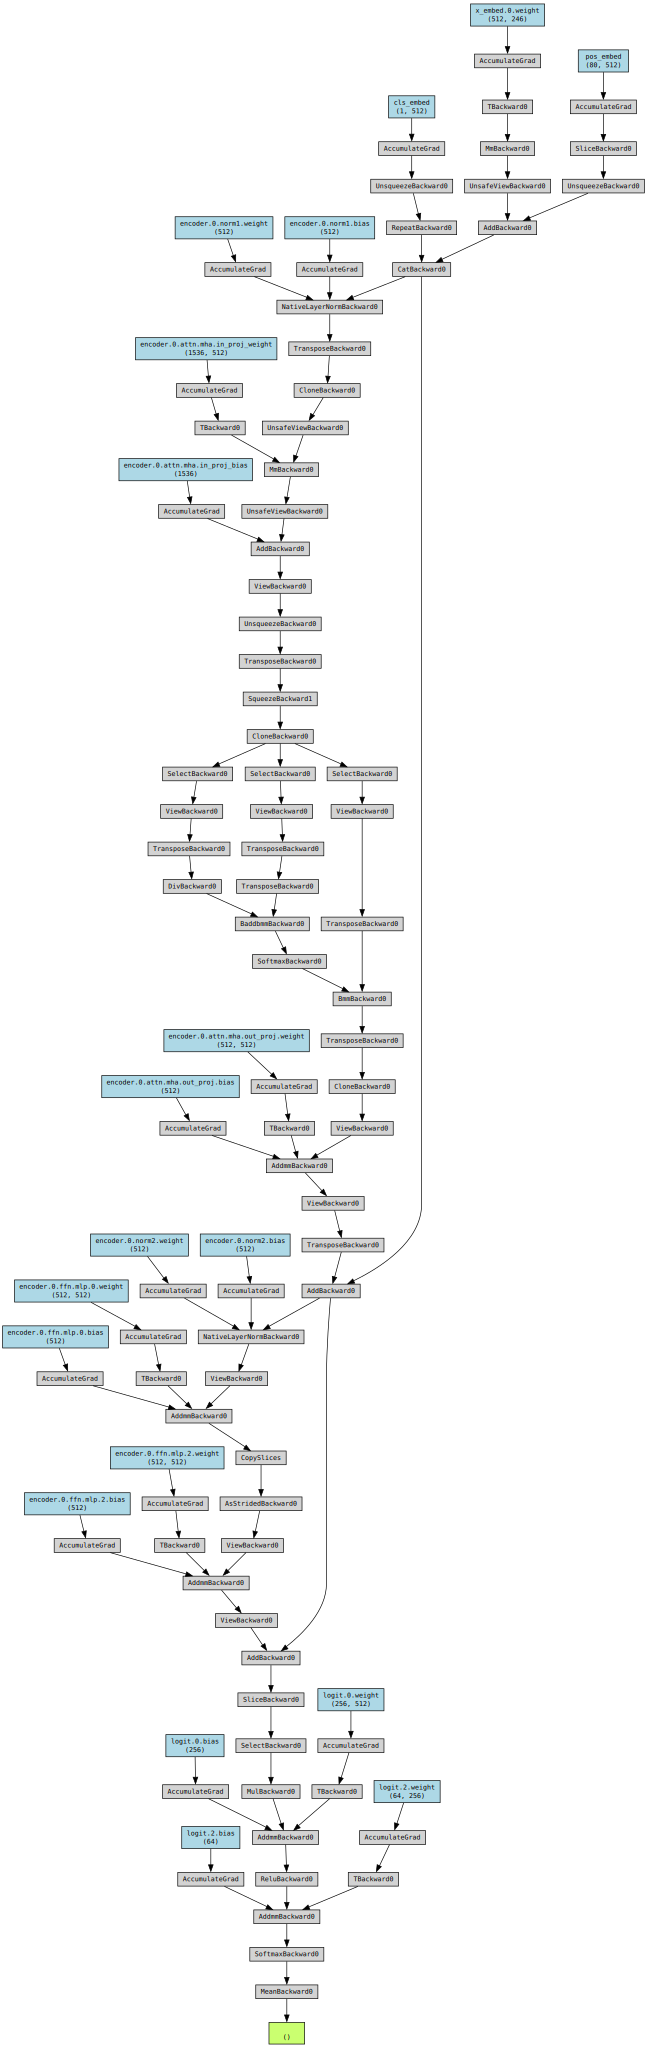

In [27]:
!pip install -q torchviz
from torchviz import make_dot
length = [3,4]
batch_size = len(length)
xyz = [np.random.uniform(-1,1,(length[b],num_point,3)) for b in range(batch_size)]
batch = {
        'label' : torch.from_numpy( np.random.choice(64,(batch_size))).long(),
        'xyz' : [torch.from_numpy(x).float() for x in xyz]
        }
model = Net()
model.logit = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 64)
)
y = model(batch)['sign']
make_dot(y.mean(), params=dict(model.named_parameters()))

In [28]:
state_dict = torch.load("/kaggle/input/gislr-saved-models/00000038.model.pth", map_location=torch.device('cuda'))['state_dict']
net_plus.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
net_plus.logit = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 64)
)

<div class="alert alert-block alert-info">
<b>Net Architecture:</b> After changing the final logit layer
</div>

In [30]:
print(net_plus)

Net(
  (x_embed): Sequential(
    (0): Linear(in_features=246, out_features=512, bias=False)
  )
  (encoder): ModuleList(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (ffn): FeedForward(
        (mlp): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (logit): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
)


<p style="color:green; font-weight:300; font-family:verdana; padding-left:20px; font-size:40px">Run train</p>

In [31]:
# Freezing the weights of the layers
for name, param in net_plus.named_parameters():
    if not name.startswith('logit'):
        param.requires_grad = False

In [32]:
def check_freezing():
    for name, param in net_plus.named_parameters():
        print(name, param.requires_grad)
# check_freezing()

In [33]:
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, net_plus.parameters()),lr=start_lr)
#scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / num_epoch)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

<h2 style="color:red; font-weight:300; font-family: badoni; font-size:15px">Load the model from check point</h2>

In [34]:
def load_checkpoint():
    start_epoch = 0
    initial_checkpoint = r"/kaggle/input/islr-self/lasilfjiogitoiet"
    f = torch.load(initial_checkpoint, map_location=lambda storage, loc: storage)
    start_epoch = f.get('epoch',0)+1
    state_dict = f['state_dict']
    net_plus.load_state_dict(state_dict,strict=False)
    optimizer.load_state_dict(f['optimizer_dict'])
    scaler.load_state_dict(f['scheduler_dict']) # Names got swapped , not an error!
    scheduler.load_state_dict(f['scaler_dict'])
    print(f"Starting from Epoch: {start_epoch}")

# if __name__=="main":
#     load_checkpoint()

In [35]:
start_epoch=0
net_plus.to(device)
hist = {"lr":[],"val_acc":[],"train_acc":[],"val_loss":[],"train_loss":[]}
def run_train():
    for i in tqdm(range(start_epoch , num_epoch+start_epoch)):
        net_plus.train()
        train_sign = []
        train_truth = []
        train_num = 0
        train_loss_sum = 0
        train_total = 0
        for t, batch in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):

            with torch.cuda.amp.autocast(enabled = True):
                batch_size = len(batch['index'])
                batch['xyz'] = [xyz.cuda() for xyz in batch['xyz']]
                batch['label'] = batch['label'].cuda()
                net_plus.output_type = ['loss', 'inference']
                output = net_plus(batch)
                loss0  = output['label_loss'].mean()


            train_sign.append(output['sign'].detach().cpu().numpy())
            train_truth.append(batch['label'].detach().cpu().numpy())
            train_num += batch_size
            
            
            optimizer.zero_grad()
            scaler.scale(loss0).backward()

            scaler.step(optimizer)
            scaler.update()
            hist["lr"].append(optimizer.param_groups[0]["lr"])
            train_loss_sum += loss0.item()
            train_total += 1
        scheduler.step()
        train_truth = np.concatenate(train_truth)
        sign = np.concatenate(train_sign)
        topk_indices = np.argsort(sign, -1)[:,-5:]
        correct_topk = np.any(np.equal(topk_indices, train_truth.reshape(-1, 1)), axis=1)
        topk_accuracy_train = np.mean(correct_topk)

        val_loss_sum = 0
        val_total = 0
        valid_num = 0
        valid_sign=[]
        ################################# Validation Step ############################
        net_plus.eval()

        for t, batch in tqdm(enumerate(valid_loader),total=len(valid_loader), leave=False):

            net_plus.output_type = ['inference']
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled = True):
                    batch_size = len(batch['index'])
                    batch['xyz'] = [xyz.cuda() for xyz in batch['xyz']]
                    batch['label'] = batch['label'].cuda()
                    output = net_plus(batch)
                    valid_loss = np_cross_entropy(output['sign'].detach().cpu(), batch['label'].detach().cpu())
                    val_loss_sum += valid_loss
                    val_total +=1
                valid_sign.append(output['sign'].detach().cpu().numpy())
                valid_num += batch_size

        valid_truth = valid_loader.dataset.df.label.values
        sign = np.concatenate(valid_sign)
        topk_indices = np.argsort(sign, -1)[:,-5:]
        correct_topk = np.any(np.equal(topk_indices, valid_truth.reshape(-1, 1)), axis=1)
        topk_accuracy_valid = np.mean(correct_topk)

        print(f"Epoch:{i} => Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {topk_accuracy_train:0.04f}")
        print(f"Epoch:{i} => Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {topk_accuracy_valid:0.04f}")
        print("="*50)
        
        hist['val_acc'].append(topk_accuracy_valid)
        hist['train_acc'].append(topk_accuracy_train)
        hist['train_loss'].append(train_loss_sum/train_total)
        hist['val_loss'].append(val_loss_sum/train_total)
        
        if i%save_iter==0:
            if i != start_epoch:
                n = i
                torch.save({
                           'state_dict': net_plus.state_dict(),
                            'epoch': i,
                            'optimizer_dict': optimizer.state_dict(),
                            'scheduler_dict':scaler.state_dict(),
                            'scaler_dict': scheduler.state_dict(),
                            }, f'{n:08d}.model.pth')
        torch.cuda.empty_cache()
        
if __name__ == "__main__":
    run_train()

100%|██████████| 56/56 [00:19<00:00,  3.39it/s]
                                               
  1%|          | 1/101 [00:25<41:47, 25.07s/it]

Epoch:0 => Train Loss: 3.9808, Train Acc: 0.1819
Epoch:0 => Val Loss: 3.5209, Val Acc: 0.4089



 98%|█████████▊| 55/56 [00:17<00:00,  3.28it/s]
                                               
  2%|▏         | 2/101 [00:47<38:34, 23.38s/it]

Epoch:1 => Train Loss: 3.2493, Train Acc: 0.4431
Epoch:1 => Val Loss: 2.7663, Val Acc: 0.5733



 98%|█████████▊| 55/56 [00:18<00:00,  3.45it/s]
                                               
  3%|▎         | 3/101 [01:10<38:07, 23.34s/it]

Epoch:2 => Train Loss: 2.5880, Train Acc: 0.6417
Epoch:2 => Val Loss: 2.2509, Val Acc: 0.6844



 98%|█████████▊| 55/56 [00:18<00:00,  3.13it/s]
                                               
  4%|▍         | 4/101 [01:33<37:39, 23.29s/it]

Epoch:3 => Train Loss: 2.1751, Train Acc: 0.7299
Epoch:3 => Val Loss: 1.9799, Val Acc: 0.7333



 98%|█████████▊| 55/56 [00:17<00:00,  2.91it/s]
                                               
  5%|▍         | 5/101 [01:57<37:14, 23.27s/it]

Epoch:4 => Train Loss: 1.9269, Train Acc: 0.7656
Epoch:4 => Val Loss: 1.7904, Val Acc: 0.7867



100%|██████████| 56/56 [00:17<00:00,  3.83it/s]
                                               
  6%|▌         | 6/101 [02:19<36:18, 22.93s/it]

Epoch:5 => Train Loss: 1.7165, Train Acc: 0.8136
Epoch:5 => Val Loss: 1.6823, Val Acc: 0.7911



 98%|█████████▊| 55/56 [00:18<00:00,  3.39it/s]
                                               
  7%|▋         | 7/101 [02:42<35:49, 22.86s/it]

Epoch:6 => Train Loss: 1.5932, Train Acc: 0.8382
Epoch:6 => Val Loss: 1.6056, Val Acc: 0.8089



 98%|█████████▊| 55/56 [00:17<00:00,  2.75it/s]
                                               
  8%|▊         | 8/101 [03:04<35:24, 22.85s/it]

Epoch:7 => Train Loss: 1.5323, Train Acc: 0.8616
Epoch:7 => Val Loss: 1.5266, Val Acc: 0.8356



 98%|█████████▊| 55/56 [00:17<00:00,  3.29it/s]
                                               
  9%|▉         | 9/101 [03:26<34:36, 22.57s/it]

Epoch:8 => Train Loss: 1.4712, Train Acc: 0.8661
Epoch:8 => Val Loss: 1.5025, Val Acc: 0.8489



 98%|█████████▊| 55/56 [00:18<00:00,  3.09it/s]
                                               
 10%|▉         | 10/101 [03:49<34:16, 22.60s/it]

Epoch:9 => Train Loss: 1.3912, Train Acc: 0.8940
Epoch:9 => Val Loss: 1.4957, Val Acc: 0.8578



 98%|█████████▊| 55/56 [00:17<00:00,  3.27it/s]
                                               
 11%|█         | 11/101 [04:12<33:54, 22.61s/it]

Epoch:10 => Train Loss: 1.4146, Train Acc: 0.8929
Epoch:10 => Val Loss: 1.4957, Val Acc: 0.8578



 98%|█████████▊| 55/56 [00:17<00:00,  3.42it/s]
                                               
 12%|█▏        | 12/101 [04:33<33:09, 22.35s/it]

Epoch:11 => Train Loss: 1.4246, Train Acc: 0.8739
Epoch:11 => Val Loss: 1.4901, Val Acc: 0.8622



 98%|█████████▊| 55/56 [00:18<00:00,  3.03it/s]
                                               
 13%|█▎        | 13/101 [04:56<32:53, 22.43s/it]

Epoch:12 => Train Loss: 1.3922, Train Acc: 0.8873
Epoch:12 => Val Loss: 1.4696, Val Acc: 0.8489



 98%|█████████▊| 55/56 [00:18<00:00,  3.15it/s]
                                               
 14%|█▍        | 14/101 [05:19<32:36, 22.49s/it]

Epoch:13 => Train Loss: 1.4165, Train Acc: 0.8795
Epoch:13 => Val Loss: 1.4458, Val Acc: 0.8622



 98%|█████████▊| 55/56 [00:17<00:00,  3.09it/s]
                                               
 15%|█▍        | 15/101 [05:41<32:20, 22.56s/it]

Epoch:14 => Train Loss: 1.4201, Train Acc: 0.8717
Epoch:14 => Val Loss: 1.4168, Val Acc: 0.8622



100%|██████████| 56/56 [00:17<00:00,  3.56it/s]
                                               
 16%|█▌        | 16/101 [06:04<31:50, 22.48s/it]

Epoch:15 => Train Loss: 1.3701, Train Acc: 0.8594
Epoch:15 => Val Loss: 1.3588, Val Acc: 0.8622



 98%|█████████▊| 55/56 [00:18<00:00,  3.43it/s]
                                               
 17%|█▋        | 17/101 [06:27<31:39, 22.61s/it]

Epoch:16 => Train Loss: 1.3486, Train Acc: 0.8795
Epoch:16 => Val Loss: 1.3341, Val Acc: 0.8844



100%|██████████| 56/56 [00:18<00:00,  3.72it/s]
                                               
 18%|█▊        | 18/101 [06:50<31:31, 22.79s/it]

Epoch:17 => Train Loss: 1.3174, Train Acc: 0.8728
Epoch:17 => Val Loss: 1.2446, Val Acc: 0.9022



 98%|█████████▊| 55/56 [00:17<00:00,  3.25it/s]
                                               
 19%|█▉        | 19/101 [07:13<31:11, 22.82s/it]

Epoch:18 => Train Loss: 1.2405, Train Acc: 0.8940
Epoch:18 => Val Loss: 1.2413, Val Acc: 0.8667



 98%|█████████▊| 55/56 [00:17<00:00,  3.70it/s]
                                               
 20%|█▉        | 20/101 [07:35<30:32, 22.62s/it]

Epoch:19 => Train Loss: 1.2527, Train Acc: 0.8962
Epoch:19 => Val Loss: 1.1711, Val Acc: 0.9022



 98%|█████████▊| 55/56 [00:18<00:00,  3.37it/s]
                                               
 21%|██        | 21/101 [07:57<30:07, 22.60s/it]

Epoch:20 => Train Loss: 1.1343, Train Acc: 0.9096
Epoch:20 => Val Loss: 1.2183, Val Acc: 0.8978



100%|██████████| 56/56 [00:17<00:00,  3.08it/s]
                                               
 22%|██▏       | 22/101 [08:20<29:57, 22.76s/it]

Epoch:21 => Train Loss: 1.1293, Train Acc: 0.9152
Epoch:21 => Val Loss: 1.0867, Val Acc: 0.9156



 98%|█████████▊| 55/56 [00:17<00:00,  3.42it/s]
                                               
 23%|██▎       | 23/101 [08:42<29:11, 22.46s/it]

Epoch:22 => Train Loss: 1.0323, Train Acc: 0.9252
Epoch:22 => Val Loss: 1.0666, Val Acc: 0.9156



100%|██████████| 56/56 [00:17<00:00,  3.94it/s]
                                               
 24%|██▍       | 24/101 [09:05<28:49, 22.46s/it]

Epoch:23 => Train Loss: 1.0014, Train Acc: 0.9375
Epoch:23 => Val Loss: 1.0540, Val Acc: 0.9244



 98%|█████████▊| 55/56 [00:18<00:00,  3.08it/s]
                                               
 25%|██▍       | 25/101 [09:28<28:43, 22.68s/it]

Epoch:24 => Train Loss: 0.9307, Train Acc: 0.9364
Epoch:24 => Val Loss: 0.9922, Val Acc: 0.9289



 98%|█████████▊| 55/56 [00:17<00:00,  3.14it/s]
                                               
 26%|██▌       | 26/101 [09:50<28:16, 22.62s/it]

Epoch:25 => Train Loss: 0.9045, Train Acc: 0.9498
Epoch:25 => Val Loss: 0.9313, Val Acc: 0.9289



100%|██████████| 56/56 [00:18<00:00,  3.66it/s]
                                               
 27%|██▋       | 27/101 [10:13<28:00, 22.70s/it]

Epoch:26 => Train Loss: 0.8248, Train Acc: 0.9621
Epoch:26 => Val Loss: 0.8978, Val Acc: 0.9378



 98%|█████████▊| 55/56 [00:18<00:00,  3.48it/s]
                                               
 28%|██▊       | 28/101 [10:36<27:42, 22.78s/it]

Epoch:27 => Train Loss: 0.8082, Train Acc: 0.9542
Epoch:27 => Val Loss: 0.8890, Val Acc: 0.9378



100%|██████████| 56/56 [00:18<00:00,  2.53it/s]
                                               
 29%|██▊       | 29/101 [11:00<27:32, 22.95s/it]

Epoch:28 => Train Loss: 0.7625, Train Acc: 0.9654
Epoch:28 => Val Loss: 0.8686, Val Acc: 0.9422



 98%|█████████▊| 55/56 [00:17<00:00,  3.14it/s]
                                               
 30%|██▉       | 30/101 [11:22<26:52, 22.72s/it]

Epoch:29 => Train Loss: 0.7361, Train Acc: 0.9721
Epoch:29 => Val Loss: 0.8660, Val Acc: 0.9422



100%|██████████| 56/56 [00:18<00:00,  3.83it/s]
                                               
 31%|███       | 31/101 [11:44<26:25, 22.65s/it]

Epoch:30 => Train Loss: 0.7368, Train Acc: 0.9676
Epoch:30 => Val Loss: 0.8660, Val Acc: 0.9422



 98%|█████████▊| 55/56 [00:18<00:00,  3.32it/s]
                                               
 32%|███▏      | 32/101 [12:07<26:02, 22.64s/it]

Epoch:31 => Train Loss: 0.7404, Train Acc: 0.9676
Epoch:31 => Val Loss: 0.8644, Val Acc: 0.9467



 98%|█████████▊| 55/56 [00:17<00:00,  3.52it/s]
                                               
 33%|███▎      | 33/101 [12:29<25:39, 22.65s/it]

Epoch:32 => Train Loss: 0.7413, Train Acc: 0.9654
Epoch:32 => Val Loss: 0.8663, Val Acc: 0.9422



 98%|█████████▊| 55/56 [00:17<00:00,  3.45it/s]
                                               
 34%|███▎      | 34/101 [12:51<24:59, 22.38s/it]

Epoch:33 => Train Loss: 0.7766, Train Acc: 0.9554
Epoch:33 => Val Loss: 0.8871, Val Acc: 0.9378



 98%|█████████▊| 55/56 [00:17<00:00,  3.58it/s]
                                               
 35%|███▍      | 35/101 [13:14<24:36, 22.37s/it]

Epoch:34 => Train Loss: 0.7879, Train Acc: 0.9609
Epoch:34 => Val Loss: 0.8574, Val Acc: 0.9422



100%|██████████| 56/56 [00:17<00:00,  3.59it/s]
                                               
 36%|███▌      | 36/101 [13:36<24:21, 22.48s/it]

Epoch:35 => Train Loss: 0.7913, Train Acc: 0.9598
Epoch:35 => Val Loss: 0.9022, Val Acc: 0.9378



 98%|█████████▊| 55/56 [00:17<00:00,  3.12it/s]
                                               
 37%|███▋      | 37/101 [13:58<23:52, 22.38s/it]

Epoch:36 => Train Loss: 0.8094, Train Acc: 0.9531
Epoch:36 => Val Loss: 0.9817, Val Acc: 0.9200



100%|██████████| 56/56 [00:17<00:00,  3.59it/s]
                                               
 38%|███▊      | 38/101 [14:21<23:28, 22.35s/it]

Epoch:37 => Train Loss: 0.7867, Train Acc: 0.9565
Epoch:37 => Val Loss: 0.9858, Val Acc: 0.9378



 98%|█████████▊| 55/56 [00:18<00:00,  3.27it/s]
                                               
 39%|███▊      | 39/101 [14:43<23:09, 22.41s/it]

Epoch:38 => Train Loss: 0.8402, Train Acc: 0.9531
Epoch:38 => Val Loss: 1.0131, Val Acc: 0.9333



 98%|█████████▊| 55/56 [00:17<00:00,  3.20it/s]
                                               
 40%|███▉      | 40/101 [15:05<22:37, 22.26s/it]

Epoch:39 => Train Loss: 0.7917, Train Acc: 0.9654
Epoch:39 => Val Loss: 0.9007, Val Acc: 0.9467



100%|██████████| 56/56 [00:18<00:00,  3.07it/s]
                                               
 41%|████      | 41/101 [15:28<22:20, 22.34s/it]

Epoch:40 => Train Loss: 0.8206, Train Acc: 0.9565
Epoch:40 => Val Loss: 0.9226, Val Acc: 0.9422



 98%|█████████▊| 55/56 [00:17<00:00,  3.43it/s]
                                               
 42%|████▏     | 42/101 [15:50<21:54, 22.27s/it]

Epoch:41 => Train Loss: 0.7984, Train Acc: 0.9554
Epoch:41 => Val Loss: 0.9406, Val Acc: 0.9467



100%|██████████| 56/56 [00:17<00:00,  3.71it/s]
                                               
 43%|████▎     | 43/101 [16:13<21:42, 22.46s/it]

Epoch:42 => Train Loss: 0.7124, Train Acc: 0.9576
Epoch:42 => Val Loss: 0.8409, Val Acc: 0.9556



100%|██████████| 56/56 [00:17<00:00,  3.69it/s]
                                               
 44%|████▎     | 44/101 [16:35<21:17, 22.41s/it]

Epoch:43 => Train Loss: 0.7213, Train Acc: 0.9654
Epoch:43 => Val Loss: 0.8470, Val Acc: 0.9467



 98%|█████████▊| 55/56 [00:17<00:00,  3.43it/s]
                                               
 45%|████▍     | 45/101 [16:58<21:00, 22.51s/it]

Epoch:44 => Train Loss: 0.6776, Train Acc: 0.9710
Epoch:44 => Val Loss: 0.8065, Val Acc: 0.9511



 98%|█████████▊| 55/56 [00:17<00:00,  2.88it/s]
                                               
 46%|████▌     | 46/101 [17:20<20:34, 22.45s/it]

Epoch:45 => Train Loss: 0.6828, Train Acc: 0.9654
Epoch:45 => Val Loss: 0.7981, Val Acc: 0.9511



100%|██████████| 56/56 [00:17<00:00,  3.67it/s]
                                               
 47%|████▋     | 47/101 [17:43<20:12, 22.46s/it]

Epoch:46 => Train Loss: 0.6477, Train Acc: 0.9676
Epoch:46 => Val Loss: 0.7818, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.15it/s]
                                               
 48%|████▊     | 48/101 [18:06<20:13, 22.89s/it]

Epoch:47 => Train Loss: 0.6064, Train Acc: 0.9743
Epoch:47 => Val Loss: 0.7420, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.02it/s]
                                               
 49%|████▊     | 49/101 [18:30<19:55, 22.99s/it]

Epoch:48 => Train Loss: 0.5704, Train Acc: 0.9833
Epoch:48 => Val Loss: 0.7438, Val Acc: 0.9556



100%|██████████| 56/56 [00:18<00:00,  3.11it/s]
                                               
 50%|████▉     | 50/101 [18:53<19:37, 23.08s/it]

Epoch:49 => Train Loss: 0.5880, Train Acc: 0.9676
Epoch:49 => Val Loss: 0.7410, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.13it/s]
                                               
 50%|█████     | 51/101 [19:16<19:12, 23.05s/it]

Epoch:50 => Train Loss: 0.5872, Train Acc: 0.9766
Epoch:50 => Val Loss: 0.7410, Val Acc: 0.9556



100%|██████████| 56/56 [00:18<00:00,  3.29it/s]
                                               
 51%|█████▏    | 52/101 [19:39<18:52, 23.11s/it]

Epoch:51 => Train Loss: 0.5659, Train Acc: 0.9754
Epoch:51 => Val Loss: 0.7362, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:17<00:00,  3.13it/s]
                                               
 52%|█████▏    | 53/101 [20:01<18:14, 22.81s/it]

Epoch:52 => Train Loss: 0.5799, Train Acc: 0.9821
Epoch:52 => Val Loss: 0.7243, Val Acc: 0.9556



100%|██████████| 56/56 [00:17<00:00,  3.80it/s]
                                               
 53%|█████▎    | 54/101 [20:24<17:51, 22.80s/it]

Epoch:53 => Train Loss: 0.5665, Train Acc: 0.9821
Epoch:53 => Val Loss: 0.7315, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:17<00:00,  3.07it/s]
                                               
 54%|█████▍    | 55/101 [20:46<17:20, 22.62s/it]

Epoch:54 => Train Loss: 0.5676, Train Acc: 0.9821
Epoch:54 => Val Loss: 0.7332, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:17<00:00,  3.55it/s]
                                               
 55%|█████▌    | 56/101 [21:09<16:59, 22.66s/it]

Epoch:55 => Train Loss: 0.5889, Train Acc: 0.9810
Epoch:55 => Val Loss: 0.7931, Val Acc: 0.9422



 98%|█████████▊| 55/56 [00:17<00:00,  3.19it/s]
                                               
 56%|█████▋    | 57/101 [21:32<16:34, 22.61s/it]

Epoch:56 => Train Loss: 0.6180, Train Acc: 0.9777
Epoch:56 => Val Loss: 0.8138, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:17<00:00,  3.58it/s]
                                               
 57%|█████▋    | 58/101 [21:54<16:07, 22.50s/it]

Epoch:57 => Train Loss: 0.6290, Train Acc: 0.9721
Epoch:57 => Val Loss: 0.7799, Val Acc: 0.9467



 98%|█████████▊| 55/56 [00:18<00:00,  2.88it/s]
                                               
 58%|█████▊    | 59/101 [22:17<15:53, 22.70s/it]

Epoch:58 => Train Loss: 0.6724, Train Acc: 0.9732
Epoch:58 => Val Loss: 0.9032, Val Acc: 0.9511



 98%|█████████▊| 55/56 [00:17<00:00,  3.67it/s]
                                               
 59%|█████▉    | 60/101 [22:39<15:27, 22.62s/it]

Epoch:59 => Train Loss: 0.6849, Train Acc: 0.9654
Epoch:59 => Val Loss: 0.8702, Val Acc: 0.9467



 98%|█████████▊| 55/56 [00:17<00:00,  3.29it/s]
                                               
 60%|██████    | 61/101 [23:02<15:05, 22.64s/it]

Epoch:60 => Train Loss: 0.6531, Train Acc: 0.9788
Epoch:60 => Val Loss: 0.8982, Val Acc: 0.9511



 98%|█████████▊| 55/56 [00:17<00:00,  3.43it/s]
                                               
 61%|██████▏   | 62/101 [23:25<14:40, 22.58s/it]

Epoch:61 => Train Loss: 0.6333, Train Acc: 0.9754
Epoch:61 => Val Loss: 0.7917, Val Acc: 0.9467



100%|██████████| 56/56 [00:17<00:00,  3.49it/s]
                                               
 62%|██████▏   | 63/101 [23:47<14:22, 22.69s/it]

Epoch:62 => Train Loss: 0.6100, Train Acc: 0.9777
Epoch:62 => Val Loss: 0.7593, Val Acc: 0.9511



 98%|█████████▊| 55/56 [00:17<00:00,  3.03it/s]
                                               
 63%|██████▎   | 64/101 [24:10<13:54, 22.56s/it]

Epoch:63 => Train Loss: 0.5921, Train Acc: 0.9810
Epoch:63 => Val Loss: 0.7504, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:17<00:00,  2.96it/s]
                                               
 64%|██████▍   | 65/101 [24:32<13:29, 22.49s/it]

Epoch:64 => Train Loss: 0.5900, Train Acc: 0.9766
Epoch:64 => Val Loss: 0.7331, Val Acc: 0.9556



100%|██████████| 56/56 [00:18<00:00,  2.71it/s]
                                               
 65%|██████▌   | 66/101 [24:55<13:16, 22.75s/it]

Epoch:65 => Train Loss: 0.5379, Train Acc: 0.9810
Epoch:65 => Val Loss: 0.7384, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.23it/s]
                                               
 66%|██████▋   | 67/101 [25:18<12:52, 22.73s/it]

Epoch:66 => Train Loss: 0.5350, Train Acc: 0.9810
Epoch:66 => Val Loss: 0.6840, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.21it/s]
                                               
 67%|██████▋   | 68/101 [25:42<12:38, 22.99s/it]

Epoch:67 => Train Loss: 0.5183, Train Acc: 0.9844
Epoch:67 => Val Loss: 0.6613, Val Acc: 0.9600



 98%|█████████▊| 55/56 [00:18<00:00,  3.07it/s]
                                               
 68%|██████▊   | 69/101 [26:05<12:18, 23.09s/it]

Epoch:68 => Train Loss: 0.4754, Train Acc: 0.9833
Epoch:68 => Val Loss: 0.6621, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.35it/s]
                                               
 69%|██████▉   | 70/101 [26:29<12:06, 23.43s/it]

Epoch:69 => Train Loss: 0.4612, Train Acc: 0.9866
Epoch:69 => Val Loss: 0.6611, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.17it/s]
                                               
 70%|███████   | 71/101 [26:52<11:38, 23.27s/it]

Epoch:70 => Train Loss: 0.4425, Train Acc: 0.9844
Epoch:70 => Val Loss: 0.6611, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.07it/s]
                                               
 71%|███████▏  | 72/101 [27:16<11:19, 23.44s/it]

Epoch:71 => Train Loss: 0.4847, Train Acc: 0.9799
Epoch:71 => Val Loss: 0.6593, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:17<00:00,  3.34it/s]
                                               
 72%|███████▏  | 73/101 [27:39<10:48, 23.17s/it]

Epoch:72 => Train Loss: 0.4651, Train Acc: 0.9855
Epoch:72 => Val Loss: 0.6666, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:17<00:00,  3.55it/s]
                                               
 73%|███████▎  | 74/101 [28:02<10:24, 23.13s/it]

Epoch:73 => Train Loss: 0.4703, Train Acc: 0.9844
Epoch:73 => Val Loss: 0.6537, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  2.54it/s]
                                               
 74%|███████▍  | 75/101 [28:24<09:57, 22.98s/it]

Epoch:74 => Train Loss: 0.5128, Train Acc: 0.9799
Epoch:74 => Val Loss: 0.6881, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.50it/s]
                                               
 75%|███████▌  | 76/101 [28:47<09:31, 22.85s/it]

Epoch:75 => Train Loss: 0.5006, Train Acc: 0.9799
Epoch:75 => Val Loss: 0.6902, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  2.62it/s]
                                               
 76%|███████▌  | 77/101 [29:10<09:11, 22.99s/it]

Epoch:76 => Train Loss: 0.5334, Train Acc: 0.9743
Epoch:76 => Val Loss: 0.6876, Val Acc: 0.9644



 98%|█████████▊| 55/56 [00:18<00:00,  3.38it/s]
                                               
 77%|███████▋  | 78/101 [29:33<08:45, 22.86s/it]

Epoch:77 => Train Loss: 0.5466, Train Acc: 0.9777
Epoch:77 => Val Loss: 0.7049, Val Acc: 0.9644



100%|██████████| 56/56 [00:18<00:00,  3.68it/s]
                                               
 78%|███████▊  | 79/101 [29:56<08:27, 23.06s/it]

Epoch:78 => Train Loss: 0.5830, Train Acc: 0.9810
Epoch:78 => Val Loss: 0.7495, Val Acc: 0.9467



100%|██████████| 56/56 [00:18<00:00,  3.72it/s]
                                               
 79%|███████▉  | 80/101 [30:19<08:03, 23.01s/it]

Epoch:79 => Train Loss: 0.6423, Train Acc: 0.9676
Epoch:79 => Val Loss: 0.7239, Val Acc: 0.9511



 98%|█████████▊| 55/56 [00:18<00:00,  3.28it/s]
                                               
 80%|████████  | 81/101 [30:43<07:43, 23.19s/it]

Epoch:80 => Train Loss: 0.5639, Train Acc: 0.9777
Epoch:80 => Val Loss: 0.7842, Val Acc: 0.9511



 98%|█████████▊| 55/56 [00:18<00:00,  2.90it/s]
                                               
 81%|████████  | 82/101 [31:05<07:17, 23.05s/it]

Epoch:81 => Train Loss: 0.5563, Train Acc: 0.9777
Epoch:81 => Val Loss: 0.7869, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.51it/s]
                                               
 82%|████████▏ | 83/101 [31:29<06:57, 23.19s/it]

Epoch:82 => Train Loss: 0.6202, Train Acc: 0.9799
Epoch:82 => Val Loss: 0.7982, Val Acc: 0.9511



 98%|█████████▊| 55/56 [00:18<00:00,  3.17it/s]
                                               
 83%|████████▎ | 84/101 [31:52<06:31, 23.03s/it]

Epoch:83 => Train Loss: 0.5408, Train Acc: 0.9833
Epoch:83 => Val Loss: 0.7083, Val Acc: 0.9644



 98%|█████████▊| 55/56 [00:18<00:00,  3.25it/s]
                                               
 84%|████████▍ | 85/101 [32:14<06:07, 22.98s/it]

Epoch:84 => Train Loss: 0.5145, Train Acc: 0.9788
Epoch:84 => Val Loss: 0.7447, Val Acc: 0.9511



100%|██████████| 56/56 [00:19<00:00,  3.04it/s]
                                               
 85%|████████▌ | 86/101 [32:38<05:49, 23.28s/it]

Epoch:85 => Train Loss: 0.4686, Train Acc: 0.9866
Epoch:85 => Val Loss: 0.6820, Val Acc: 0.9600



 98%|█████████▊| 55/56 [00:18<00:00,  3.20it/s]
                                               
 86%|████████▌ | 87/101 [33:01<05:24, 23.17s/it]

Epoch:86 => Train Loss: 0.4820, Train Acc: 0.9866
Epoch:86 => Val Loss: 0.6566, Val Acc: 0.9600



100%|██████████| 56/56 [00:19<00:00,  2.69it/s]
                                               
 87%|████████▋ | 88/101 [33:25<05:03, 23.32s/it]

Epoch:87 => Train Loss: 0.3903, Train Acc: 0.9866
Epoch:87 => Val Loss: 0.6542, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.01it/s]
                                               
 88%|████████▊ | 89/101 [33:48<04:38, 23.20s/it]

Epoch:88 => Train Loss: 0.4314, Train Acc: 0.9900
Epoch:88 => Val Loss: 0.6381, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  2.83it/s]
                                               
 89%|████████▉ | 90/101 [34:12<04:16, 23.34s/it]

Epoch:89 => Train Loss: 0.4189, Train Acc: 0.9877
Epoch:89 => Val Loss: 0.6380, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.28it/s]
                                               
 90%|█████████ | 91/101 [34:34<03:52, 23.20s/it]

Epoch:90 => Train Loss: 0.3854, Train Acc: 0.9855
Epoch:90 => Val Loss: 0.6380, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.46it/s]
                                               
 91%|█████████ | 92/101 [34:58<03:29, 23.32s/it]

Epoch:91 => Train Loss: 0.4118, Train Acc: 0.9922
Epoch:91 => Val Loss: 0.6351, Val Acc: 0.9556



100%|██████████| 56/56 [00:18<00:00,  3.62it/s]
                                               
 92%|█████████▏| 93/101 [35:21<03:05, 23.21s/it]

Epoch:92 => Train Loss: 0.3979, Train Acc: 0.9922
Epoch:92 => Val Loss: 0.6237, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  2.83it/s]
                                               
 93%|█████████▎| 94/101 [35:45<02:43, 23.32s/it]

Epoch:93 => Train Loss: 0.4259, Train Acc: 0.9866
Epoch:93 => Val Loss: 0.6307, Val Acc: 0.9644



100%|██████████| 56/56 [00:18<00:00,  3.08it/s]
                                               
 94%|█████████▍| 95/101 [36:08<02:19, 23.24s/it]

Epoch:94 => Train Loss: 0.4198, Train Acc: 0.9877
Epoch:94 => Val Loss: 0.6399, Val Acc: 0.9556



 98%|█████████▊| 55/56 [00:18<00:00,  3.31it/s]
                                               
 95%|█████████▌| 96/101 [36:31<01:55, 23.15s/it]

Epoch:95 => Train Loss: 0.4385, Train Acc: 0.9866
Epoch:95 => Val Loss: 0.6530, Val Acc: 0.9644



 98%|█████████▊| 55/56 [00:19<00:00,  3.20it/s]
                                               
 96%|█████████▌| 97/101 [36:54<01:33, 23.29s/it]

Epoch:96 => Train Loss: 0.5152, Train Acc: 0.9844
Epoch:96 => Val Loss: 0.6895, Val Acc: 0.9556



100%|██████████| 56/56 [00:18<00:00,  3.56it/s]
                                               
 97%|█████████▋| 98/101 [37:18<01:10, 23.54s/it]

Epoch:97 => Train Loss: 0.4730, Train Acc: 0.9821
Epoch:97 => Val Loss: 0.7512, Val Acc: 0.9556



100%|██████████| 56/56 [00:17<00:00,  3.79it/s]
                                               
 98%|█████████▊| 99/101 [37:41<00:46, 23.40s/it]

Epoch:98 => Train Loss: 0.4679, Train Acc: 0.9888
Epoch:98 => Val Loss: 0.8137, Val Acc: 0.9600



 98%|█████████▊| 55/56 [00:18<00:00,  3.19it/s]
                                               
 99%|█████████▉| 100/101 [38:04<00:23, 23.29s/it]

Epoch:99 => Train Loss: 0.5514, Train Acc: 0.9699
Epoch:99 => Val Loss: 0.7532, Val Acc: 0.9600



 98%|█████████▊| 55/56 [00:19<00:00,  3.15it/s]
                                               
100%|██████████| 101/101 [38:28<00:00, 22.86s/it]

Epoch:100 => Train Loss: 0.5342, Train Acc: 0.9732
Epoch:100 => Val Loss: 0.7662, Val Acc: 0.9511


In [36]:
def plot_curves(hist):
    fig, axs = plt.subplots(3, 2, figsize=(18,18))
    
    # Generate x-axis values (epochs and steps)
    epochs = range(1, len(hist['lr']) + 1)
    
    
    axs[0,0].plot(hist['train_loss'])
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_ylabel('train_loss')
    axs[0,0].set_title('Variation of Training Loss')
    axs[0,1].plot(hist['val_loss'])
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_ylabel('val_loss')
    axs[0,1].set_title('Variation of Validation Loss')
    axs[1,0].plot(hist['train_acc'])
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_ylabel('train_acc')
    axs[1,0].set_title('Variation of Training Accuracy')
    axs[1,1].plot(hist['val_acc'])
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('val_acc')
    axs[1,1].set_title('Variation of Validation Accuracy')
    axs[2,0].plot(hist['lr'])
    axs[2,0].set_xlabel('epoch')
    axs[2,0].set_ylabel('lr')
    axs[2,0].set_title('Variation of Learning rate')

    plt.tight_layout()
    plt.show()


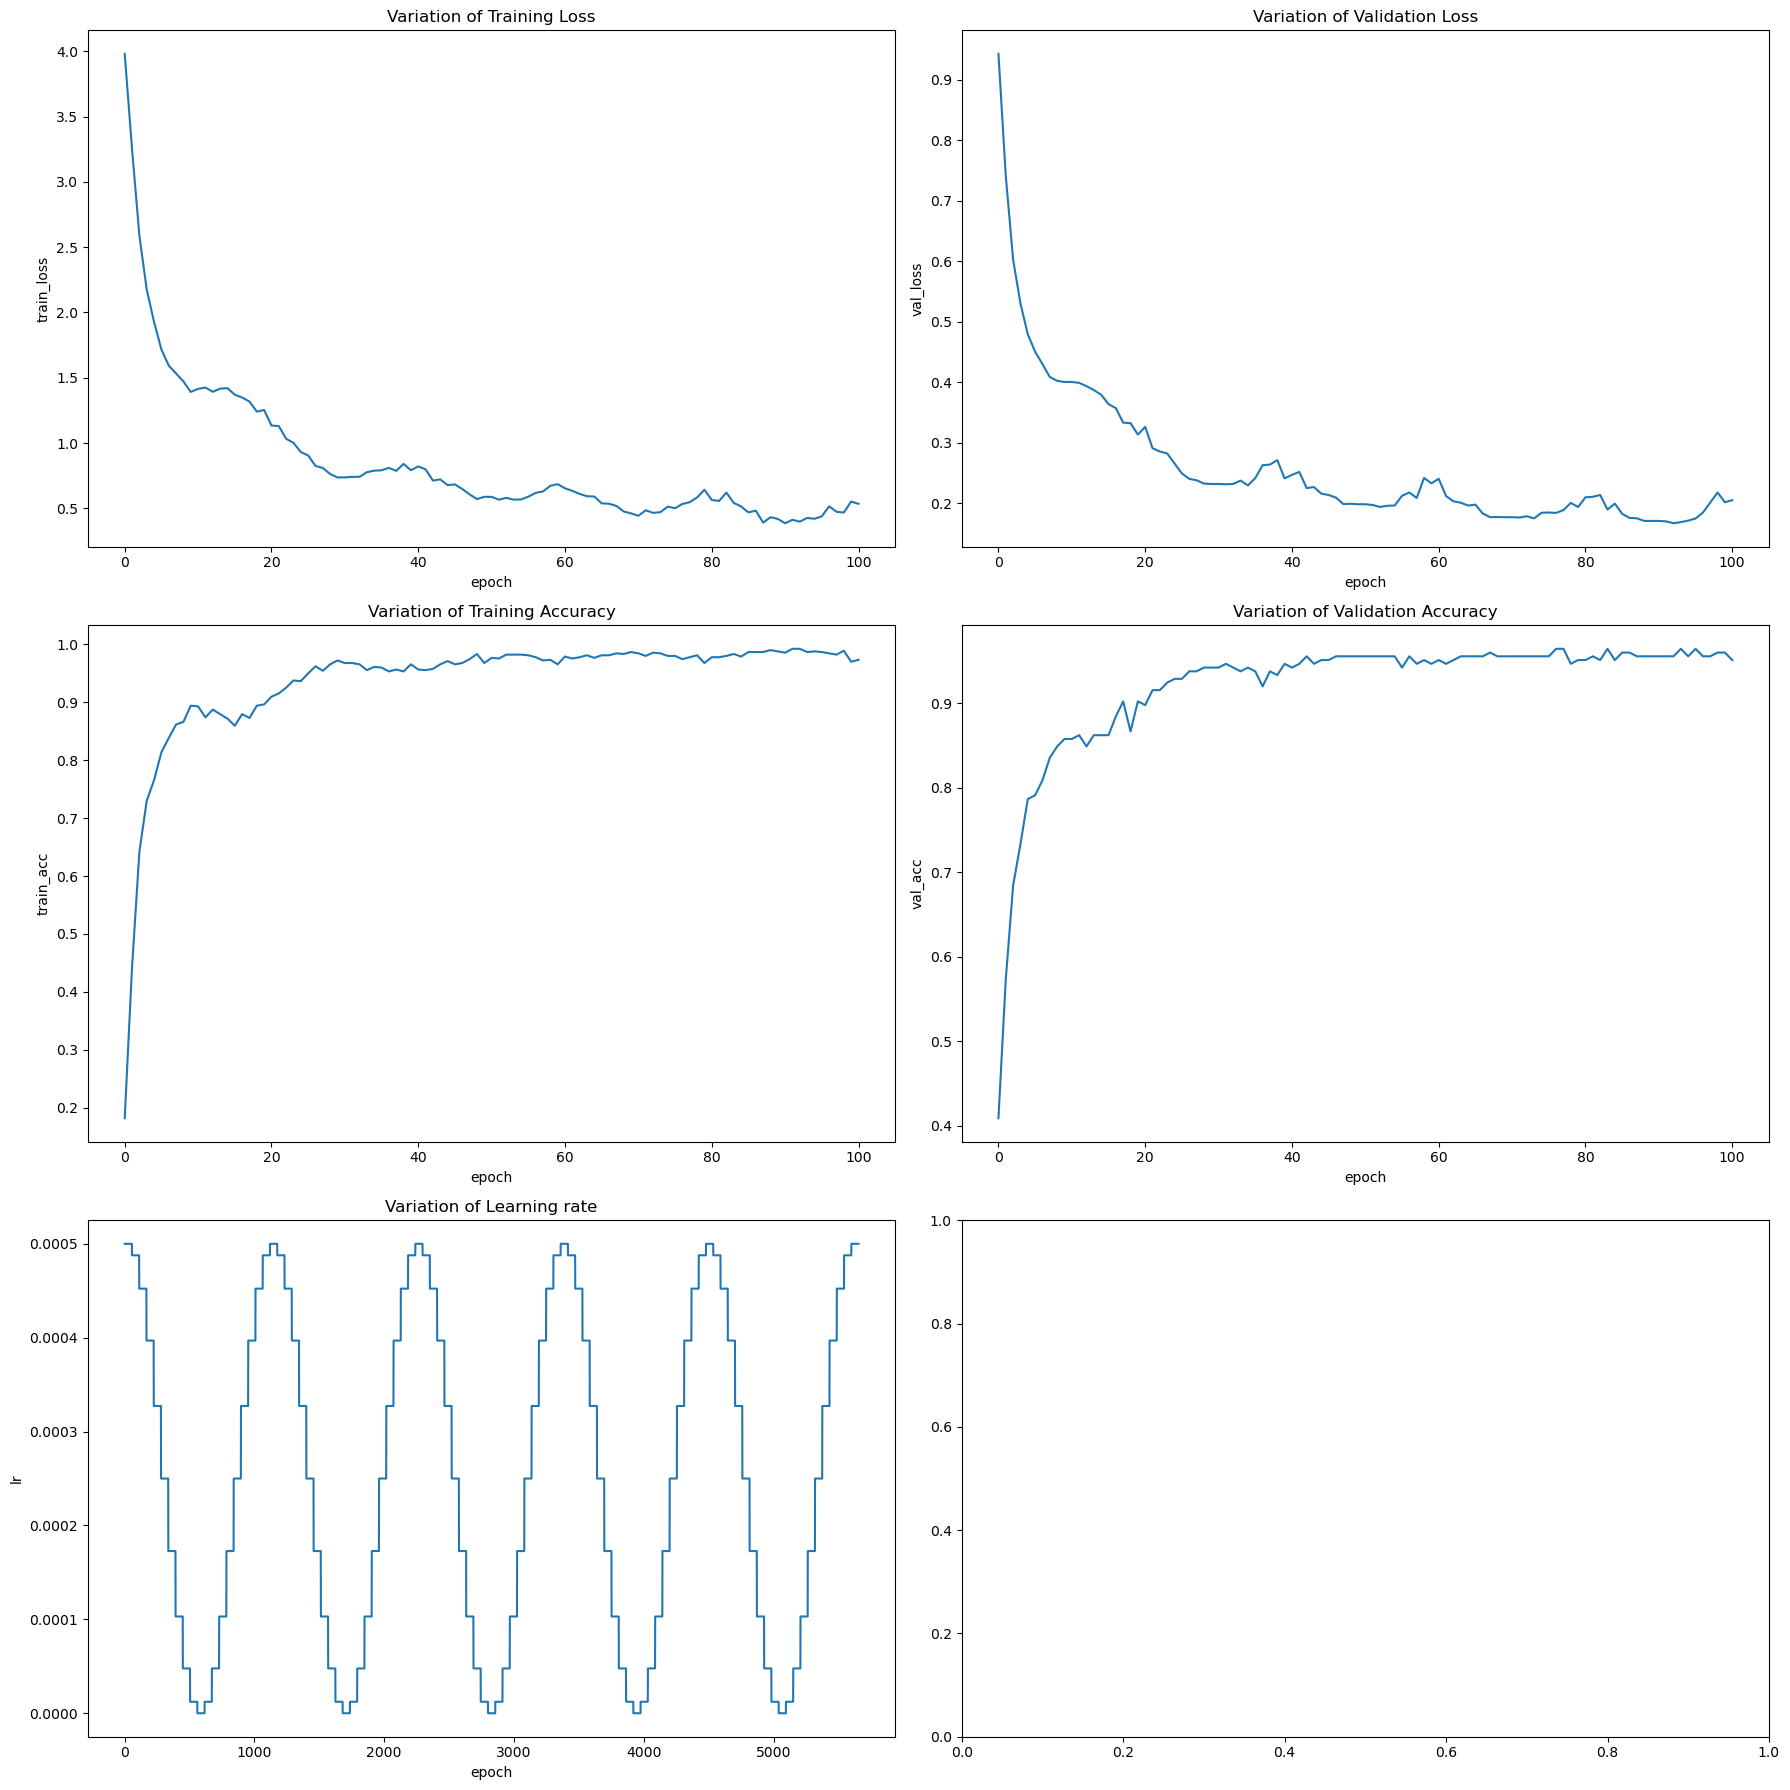

In [37]:
plot_curves(hist)

In [38]:
# net_plus.load_state_dict(torch.load('/kaggle/working/00000020.model.pth', map_location= torch.device('cuda'))['state_dict'])

<p style="color:red; font-weight:600; font-size:24px;">Inference on one example from validation set</p>
<p style="padding-left:60px">> Modify collate function, or take just one example from the dataset and set up inference</p>

In [39]:
def inf_null_collate(batch):
    batch_size = len(batch)
    d = {}
    key = batch.keys()
    for k in key:
        d[k] = [b[k] for b in batch]
    d['label'] = torch.LongTensor(d['label'])
    return d

In [40]:
def ft_run_inference_on_random_example():
    kaggle_df = pd.read_csv('/kaggle/input/include-dataset/train-preprocessed.csv')
    randno = np.random.randint(len(kaggle_df))
    valid_df = kaggle_df[kaggle_df.index==randno].reset_index(drop=True)
    valid_dataset = IncludeDataset(valid_df,)
    print("Actual label: ",valid_df.iloc[0]['label'])
    valid_loader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size  = 1,
        drop_last   = False,
        num_workers = 0,
        pin_memory  = False,
        collate_fn = null_collate,
    )
    net.eval()
    for t, batch in enumerate(valid_loader):
        net_plus.output_type = ['inference']
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled = True):
                batch['xyz'] = [xyz.cuda() for xyz in batch['xyz']]
                batch['label'] = batch['label'].cuda()
                output = net_plus(batch)
                top_values, top_indices = torch.topk(output['sign'].detach().cpu(), k=5)
                print(top_indices)
                print(top_values)

if __name__=="__main__":
    ft_run_inference_on_random_example()

Actual label:  11
tensor([[ 1, 62, 17, 53, 11]])
tensor([[0.2367, 0.2191, 0.2174, 0.0759, 0.0577]])
